In [1]:
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import datetime as dt
import tqdm
import glob
import matplotlib.pyplot as plt
import os
import zipfile
import h5py

def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1b/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: ")#+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[8].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0, second=0)) & (file_dates <= times[1].replace(hour=0, minute=0,second=0))]
        extract_to = "/scratch/w40/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)    
    
def load_radar(rid, time, radar_t_delta=0):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    times = [time+dt.timedelta(seconds=-60), time+dt.timedelta(seconds=60)]
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/w40/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
        
    #radar_file = pyart.io.read_grid(target_files[0])
    radar_file = xr.open_dataset(target_files[0])
    
    _ = [os.remove(f) for f in grid_files]
    
    return radar_file   

def reconstruct_grid(f, group_id):
        
        #From h5 grid objects (f), reconstruct the radar grid
        
        bbox = f[group_id].attrs["bbox"]
        x = f["lon/lon"][:]
        y = f["lat/lat"][:]
        recon = np.zeros(x.shape)
        recon[bbox[0]:bbox[2],bbox[1]:bbox[3]] = f[group_id+"/cell_mask"][:]
        
        return recon, x, y
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def get_mask(lon,lat,thresh=0.5):
    #Return lsm for a given domain (with lats=lat and lons=lon)
    lsm,nat_lon,nat_lat = get_lsm()
    lon_ind = np.where((nat_lon >= lon[0]) & (nat_lon <= lon[-1]))[0]
    lat_ind = np.where((nat_lat >= lat[-1]) & (nat_lat <= lat[0]))[0]
    lsm_domain = lsm[(lat_ind[0]):(lat_ind[-1]+1),(lon_ind[0]):(lon_ind[-1]+1)]
    lsm_domain = np.where(lsm_domain > thresh, 1, 0)

    return lsm_domain

def get_lsm():
    #Load the ERA5 land-sea fraction
    lsm_file = nc.Dataset("/g/data/rt52/era5/single-levels/reanalysis/lsm/1979/lsm_era5_oper_sfc_19790101-19790131.nc")
    lsm = np.squeeze(lsm_file.variables["lsm"][0])
    lsm_lon = np.squeeze(lsm_file.variables["longitude"][:])
    lsm_lat = np.squeeze(lsm_file.variables["latitude"][:])
    lsm_file.close()
    return [lsm,lsm_lon,lsm_lat]


def cape_shear_data(var, time, lat, lon, r=0, func=np.max):
    #print("\n",lat, lon, time)
    f = xr.open_dataset(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_"\
                            +time.strftime("%Y%m")+"*.nc")[0])[var].sel({"time":time.replace(minute=0)})

    lats = f.coords.get("lat").values
    lons = f.coords.get("lon").values
    x,y = np.meshgrid(lons,lats)
    mask = get_mask(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    if r>0:
        a,b = np.where( (dist_km <= r) & (mask==1) )
        subset = f.isel_points("points",lat=a, lon=b)
        sliced = subset.apply(func)
    else:
        dist_km = np.where(mask==1, dist_km, 9999)
        temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist_km),dist_km.shape)
        sliced = f.isel({"lon":temp_lon, "lat":temp_lat})

    return pd.DataFrame({"var":[np.round(sliced[v].values,1) for v in var]}, index=var)


In [2]:
path = "/g/data/eg3/ab4502/TINTobjects/"
details_list = [\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2006,9,24,1,41)], "rid":"2", "title":"a) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2009,11,20,3,6)], "rid":"2", "title":"b) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,3,6,3,30)], "rid":"2", "title":"c) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,6,17,0,25)], "rid":"2", "title":"d) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,11,18,7,4)], "rid":"2", "title":"e) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,12,25,6,45)], "rid":"2", "title":"f) Melbourne:  UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2012,2,26,9,11)], "rid":"2", "title":"g) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2013,3,21,3,45)], "rid":"2", "title":"h) Melbourne: UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2015,2,28,9,25)], "rid":"2", "title":"i) Melbourne:  UTC"},\
       \
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2010,8,2,15,43)], "rid":"71", "title":"a) Sydney:  UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2012,8,10,4,21)], "rid":"71", "title":"b) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2013,2,23,13,43)], "rid":"71", "title":"c) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2014,10,14,11,39)], "rid":"71", "title":"d) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,3,1,4,34)], "rid":"71", "title":"e) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,12,16,2,3)], "rid":"71", "title":"f) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,1,14,4,20)], "rid":"71", "title":"g) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,6,4,3,42)], "rid":"71", "title":"h) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2017,4,9,8,3)], "rid":"71", "title":"i) Sydney: UTC"},\
       \
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2010,12,16,3,25)], "rid":"66", "title":"a) Amberley: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2011,1,18,5,5)], "rid":"66", "title":"b) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2011,10,7,19,22)], "rid":"50", "title":"c) Oakey: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2013,10,18,4,4)], "rid":"50", "title":"d) Oakey: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2013,11,23,9,45)], "rid":"66", "title":"e) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2014,1,23,4,52)], "rid":"50", "title":"f) Oakey UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2016,1,29,4,22)], "rid":"50", "title":"g) Oakey UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2016,12,18,4,14)], "rid":"66", "title":"h) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2018,2,13,7,5)], "rid":"50", "title":"i) Oakey: UTC"},\
       \
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2007,10,27,9,3)], "rid":"27", "title":"a) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2008,12,9,6,18)], "rid":"27", "title":"b) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2010,12,7,9,27)], "rid":"27", "title":"c) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2011,11,8,9,47)], "rid":"27", "title":"d) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,1,29,4,42)], "rid":"27", "title":"e) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,11,30,8,33)], "rid":"27", "title":"f) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2014,10,31,7,52)], "rid":"27", "title":"g) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2015,12,7,11,20)], "rid":"27", "title":"h) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2017,12,18,11,30)], "rid":"27", "title":"i) "},\
         ]

fids = [d["rid"]+"_"+d["time"][0].strftime("%Y%m%d")+"_"+d["time"][0].strftime("%Y%m%d")+"_aws.csv" for d in details_list]


In [3]:
cols = ["time","rid","scan","uid","area_km","vol","speed","speed_rnge","angle","conv_pct","azi_shear",
        "duration_mins","major_axis_length","minor_axis_length","eccentricity","field_max","local_max","max_alt"]

sums = {"scan":np.min,
        "rid":np.min,
        "time":np.min,
        "vol":np.median,
        "area_km":np.median,
        "field_max":np.max, 
        "min_alt":np.median,
        "max_alt":np.median,
        "local_max":np.median,
        "major_axis_length":np.median,
        "minor_axis_length":np.median,        
        "eccentricity":np.median,
        "angle":np.median,
        "speed":np.median,
        "speed_rnge":np.median,
        "duration_mins":np.median,
        "azi_shear":np.max,
        "conv_pct":np.median}

stats_inst = pd.DataFrame()
stats_all = pd.DataFrame()
stats_sum = pd.DataFrame()
gust = []
for f in fids:
    if f == "2_20200131_20200131_aws.csv":
        scan, uid = pd.read_csv(path+f).dropna(subset=["gust"]).sort_values("gust", ascending=False).query("in10km==1").iloc[1][["scan","uid"]].values
        gust.append(pd.read_csv(path+f).dropna(subset=["gust"]).sort_values("gust", ascending=False).query("in10km==1").iloc[1]["gust"])
    elif f == "2_20100306_20100306_aws.csv":
        scan, uid = pd.read_csv(path+f).dropna(subset=["gust"]).sort_values("gust", ascending=False).query("in10km==1").iloc[0][["scan","uid10"]].values
        gust.append(pd.read_csv(path+f).dropna(subset=["gust"]).sort_values("gust", ascending=False).query("in10km==1").iloc[0]["gust"])        
    else:
        scan, uid = pd.read_csv(path+f).dropna(subset=["gust"]).sort_values("gust", ascending=False).query("in10km==1").iloc[0][["scan","uid"]].values
        gust.append(pd.read_csv(path+f).dropna(subset=["gust"]).sort_values("gust", ascending=False).query("in10km==1").iloc[0]["gust"])
    storm_df = pd.read_csv(path+f.replace("_aws",""))
    storm_df["rid"] = f.split("_")[0]    
    storm_df_agg = storm_df.groupby("uid").agg(sums)
    stats_inst = pd.concat([stats_inst, storm_df.query("(scan=="+str(scan)+") & (uid=="+str(uid)+")")[cols]], axis=0)
    stats_sum = pd.concat([stats_sum, storm_df_agg.loc[int(uid)]], axis=1)
    stats_all = pd.concat([stats_all, storm_df.query("(uid=="+str(uid)+")")[cols]], axis=0)  
stats_sum = stats_sum.T.reset_index().rename(columns={"index":"uid"}).set_index("time")
stats_inst = stats_inst.reset_index().drop(columns=["index"]).set_index("time")
stats_all = stats_all.set_index("uid")
stats_sum["gust"] = gust
stats_inst["gust"] = gust

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [4]:
stats_inst

,rid,scan,uid,area_km,vol,speed,speed_rnge,angle,conv_pct,azi_shear,duration_mins,major_axis_length,minor_axis_length,eccentricity,field_max,local_max,max_alt,gust
time,,,,,,,,,,,,,,,,,,
2006-09-24 01:40:02,2,10,3,2288.0,2240.5,30.583,5.308,69.328,0.063,NaN,170.016667,101.228,55.913,0.834,48.000000,9.0,5.0,26.2
2009-11-20 03:00:32,2,30,49,1590.0,2636.5,39.264,18.620,121.559,0.264,3.132,36.000000,79.425,55.923,0.710,45.812000,6.0,6.0,26.2
2010-03-06 03:24:32,2,34,4,2797.0,8570.0,16.909,0.704,125.549,0.661,5.012,168.016667,118.430,43.608,0.930,70.125000,4.0,9.5,28.3
2010-06-17 00:24:28,2,4,1,5563.0,8077.0,41.531,3.000,105.385,0.061,2.938,90.000000,118.141,66.975,0.824,52.438000,7.0,4.0,25.7
2011-11-18 07:00:35,2,70,75,1678.0,4790.5,23.239,2.832,75.993,0.524,3.862,126.016667,74.055,42.037,0.823,54.562000,3.0,9.0,25.7
2011-12-25 06:42:36,2,67,37,1262.0,7662.5,16.743,2.437,91.416,0.643,4.982,258.016667,61.604,29.016,0.882,67.125000,1.0,13.0,27.8
2012-02-26 09:06:32,2,91,90,1460.0,5325.5,13.525,5.867,122.661,0.579,2.625,53.833333,76.874,33.481,0.900,58.312000,3.0,9.5,27.3
2013-03-21 03:42:31,2,37,166,297.0,462.0,29.853,9.910,145.892,0.421,2.720,12.000000,25.819,18.773,0.687,43.188000,1.0,4.0,26.7
2015-02-28 09:24:34,2,94,142,31464.0,132906.0,17.483,0.829,85.051,0.775,2.750,408.050000,255.770,180.320,0.709,64.561996,43.0,8.5,34.0


In [5]:
for k in cols:
    if k not in ["rid","uid","scan","time"]:
        stats_sum[k] = pd.to_numeric(stats_sum[k])
        stats_all[k] = pd.to_numeric(stats_all[k])
        stats_inst[k] = pd.to_numeric(stats_inst[k])

In [7]:
data=stats_inst[cols[1:]+["gust"]]
data["class2"] = None

In [9]:
data["aspect"] = data["major_axis_length"] / data["minor_axis_length"]
#Linear
data.loc[(data.aspect>=3) & (data.major_axis_length>=100),"class2"] = "Linear"
#Non-linear
data.loc[(data.aspect<3) & (data.major_axis_length>=100),"class2"] = "Non-linear"
#Cellular
data.loc[(data.local_max == 1),"class2"] = "Cellular"
#Macroburst
data.loc[(data.local_max>=2) & (data.major_axis_length<100),"class2"] = "Cell cluster"
#Supercell
data.loc[(data.azi_shear>4.5) & ((data.aspect<3) | (data.major_axis_length<100)),"class2"] = "Supercellular"
#Shallow
data.loc[(data.conv_pct<.35),"class2"] = "Stratiform"

In [10]:
letters = ["a","b","c","d","e","f","g","h","i"]
labels = []
for i in [3,4,5,6]:
    for l in letters:
        labels.append(" ("+str(i)+l+")")

round_dict = {"Major axis (km)":1, "Aspect ratio":1, "Aziumthal shear (s^-1)":6, "Convective pixel fraction":2}
data.loc[data["rid"]=="2","Location"] = "Melbourne"
data.loc[data["rid"]=="71","Location"] = "Sydney"
data.loc[data["rid"]=="50","Location"] = "Oakey"
data.loc[data["rid"]=="66","Location"] = "Amberley"
data.loc[data["rid"]=="27","Location"] = "Woomera"
data.Location = data.Location+labels
data["azi_shear"] = data["azi_shear"] / 1000
data["local_max"] = data["local_max"].astype(int)
data[["Location","major_axis_length","aspect","local_max","azi_shear","conv_pct","class2"]].\
rename(columns={"major_axis_length":"Major axis (km)","aspect":"Aspect ratio","local_max":"Local maxima","azi_shear":"Aziumthal shear (s^-1)",\
                "conv_pct":"Convective pixel fraction","max_alt":"Maximum altitude (km)","class2":"Class"}).round(round_dict).to_latex("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/storm_stats.tex")
data["azi_shear"] = data["azi_shear"] * 1000

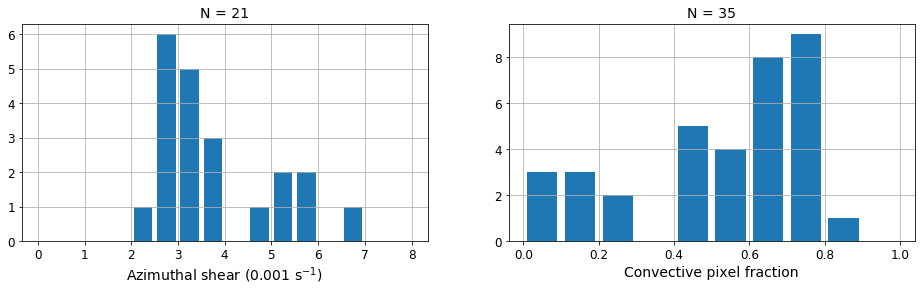

In [15]:
plt.figure(figsize=[16,4])
plt.subplot(1,2,1)
plt.hist(data.azi_shear,rwidth=0.8,bins=np.arange(0,8.5,0.5),color="tab:blue")
plt.gca().grid()
plt.title("N = "+str((~data.azi_shear.isna()).sum()),size=14)
plt.xlabel("Azimuthal shear (0.001 s$^{-1}$)",size=14)
plt.gca().tick_params(labelsize=12)

plt.subplot(1,2,2)
plt.hist(data.conv_pct,rwidth=0.8,bins=np.arange(0,1.1,.1),color="tab:blue")
plt.gca().grid()
plt.title("N = "+str((~data.conv_pct.isna()).sum()),size=14)
plt.xlabel("Convective pixel fraction",size=14)
plt.gca().tick_params(labelsize=12)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/tint_stats_distribution_2.jpeg",dpi=1000,bbox_inches="tight")

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


Text(0.5, 0, 'Convective pixel fraction')

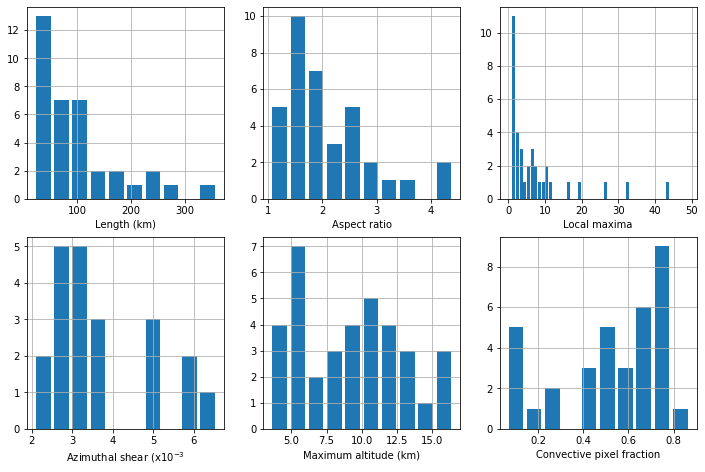

In [12]:
import seaborn as sns

plt.figure(figsize=[12,12])
plt.subplot(3,3,1);stats_inst.major_axis_length.hist(rwidth=0.8); plt.xlabel("Length (km)")
stats_inst.aspect_ratio = stats_inst.major_axis_length/stats_inst.minor_axis_length
plt.subplot(3,3,2);stats_inst.aspect_ratio.hist(rwidth=0.8); plt.xlabel("Aspect ratio")
plt.subplot(3,3,3);stats_inst.local_max.hist(bins=np.arange(0,50,1),rwidth=0.8); plt.xlabel("Local maxima")
plt.subplot(3,3,4);stats_inst.azi_shear.hist(rwidth=0.8); plt.xlabel("Azimuthal shear (x10$^{-3}$")
plt.subplot(3,3,5);stats_inst.max_alt.hist(rwidth=0.8); plt.xlabel("Maximum altitude (km)")
plt.subplot(3,3,6);stats_inst.conv_pct.hist(rwidth=0.8); plt.xlabel("Convective pixel fraction")


/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = get

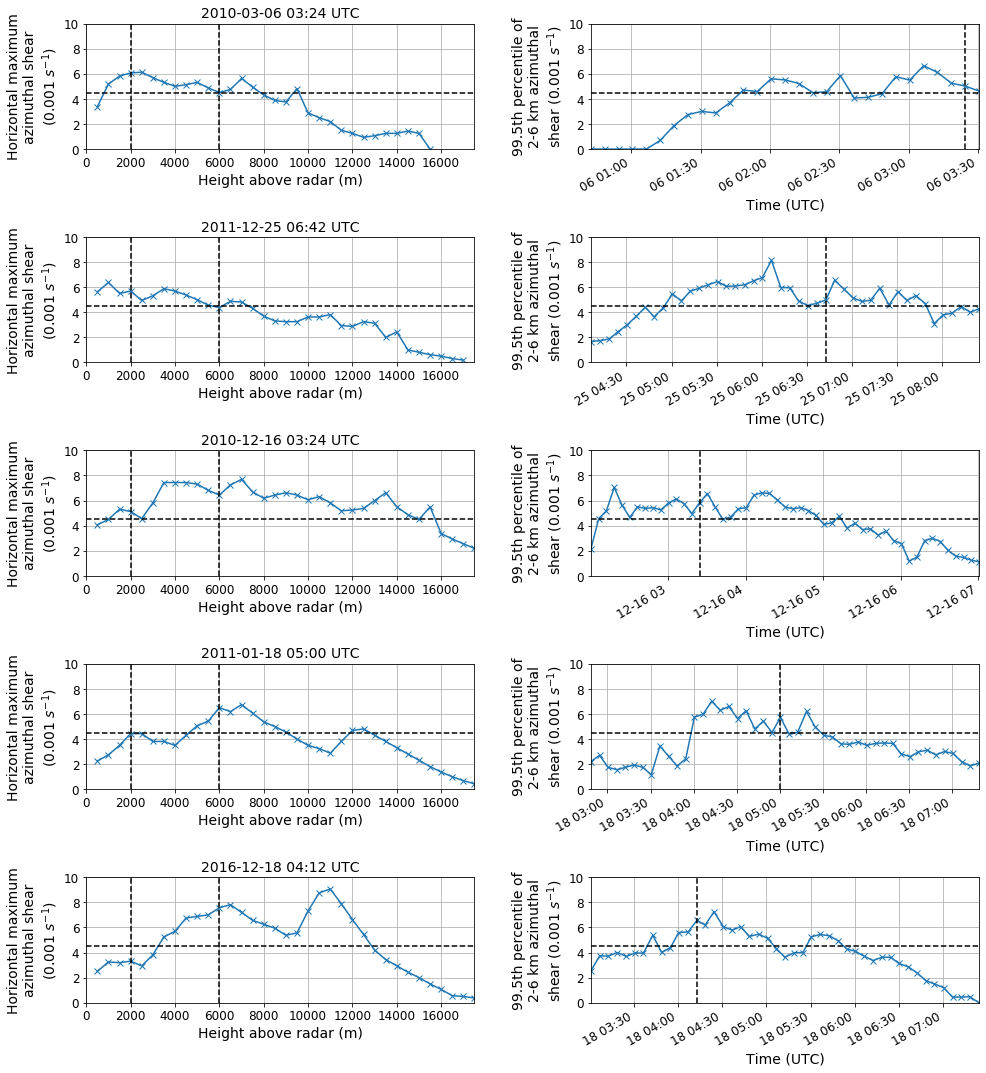

In [13]:
cnt=1
plt.figure(figsize=[16,20])
stats_inst["aspect_ratio"] = stats_inst["major_axis_length"]/stats_inst["minor_axis_length"]

for t in stats_inst.query("(azi_shear>4.5) & ((major_axis_length<100) | (aspect_ratio<3))").index:
    ax=plt.subplot(5,2,cnt)
    
    rid=stats_inst.loc[t].rid
    uid=stats_inst.loc[t].uid    
    t=dt.datetime.strptime(t, "%Y-%m-%d %H:%M:%S")
    temp = pd.read_csv(path+"/"+rid+"_"+t.strftime("%Y%m%d")+"_"+t.strftime("%Y%m%d")+".csv").query("uid=="+str(uid))
    
    #for scan_time in tqdm.tqdm(pd.DatetimeIndex(temp.time)):
    scan_time=t
    radar = load_radar(rid, scan_time)
    file_id = rid+"_"+scan_time.strftime("%Y%m%d_%Y%m%d")
    h5 = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+file_id+".h5", "r")
    r, x, y = reconstruct_grid(h5,scan_time.strftime("%Y%m%d%H%M%S")+"/"+str(uid))
    np.abs(xr.where(r==1,radar.azshear,np.nan).isel({"time":0})).max(("x","y")).plot(marker="x",ax=ax)
    ax.axhline(4.5,color="k",ls="--")
    ax.axvline(2000,color="k",ls="--")
    ax.axvline(6000,color="k",ls="--")
    ax.grid()    
    ax.set_xlabel("Height above radar (m)",size=14)
    ax.set_ylabel("Horizontal maximum\nazimuthal shear\n(0.001 $s^{-1}$)",size=14)
    ax.set_ylim([0,10])
    ax.set_title(t.strftime("%Y-%m-%d %H:%M")+" UTC",size=14)
    ax.tick_params(labelsize=12)
    ax.set_xlim([0,17500])
    
    ax2=plt.subplot(5,2,cnt+1)
    temp["time"] = pd.DatetimeIndex(temp.time)
    time_step = pd.concat([temp.time.diff(1).abs(),temp.time.diff(-1).abs()],axis=1).min(axis=1).mean().total_seconds()
    temp.set_index("time").azi_shear.plot(ax=ax2,marker="x")
    ax2.axhline(4.5,color="k",ls="--")
    ax2.axvline(t,color="k",ls="--")    
    ax2.grid()
    ax2.set_ylabel("99.5th percentile of\n2-6 km azimuthal\nshear (0.001 $s^{-1}$)",size=14)
    ax2.set_xlabel("Time (UTC)",size=14)
    ax2.set_ylim([0,10])
    ax2.tick_params(labelsize=12)    
    
    cnt=cnt+2
    
plt.subplots_adjust(hspace=0.7,wspace=0.3)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/azi_shear_structure.jpeg",quality=100,bbox_inches="tight")